In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import nn
from torch.functional import F

In [2]:
def scotts_factor(n):
    """Compute Scott's factor.
    Returns
    -------
    s : float
        Scott's factor.
    """
    return np.power(n, -1./5)

In [36]:
import torch
from torch.distributions import Normal
from torch.distributions.distribution import Distribution

class GaussianKDE(Distribution):
    def __init__(self, X, bw, weights=None):
        """
        X : tensor (n, d)
          `n` points with `d` dimensions to which KDE will be fit
        bw : numeric
          bandwidth for Gaussian kernel
        """
        self.X = X
        self.bw = bw
        self.n = X.shape[0]
        self.mvn = Normal(loc=torch.zeros(1), scale=1)
        
        if weights is not None:
            self.weights = weights/sum(weights)
        else:
            self.weights = (1/len(X))*torch.ones(len(X))
        self.neff = 1/sum(self.weights**2)

    def score_samples(self, Y, X=None):
        """Returns the kernel density estimates of each point in `Y`.

        Parameters
        ----------
        Y : tensor (m, d)
          `m` points with `d` dimensions for which the probability density will
          be calculated
        X : tensor (n, d), optional
          `n` points with `d` dimensions to which KDE will be fit. Provided to
          allow batch calculations in `log_prob`. By default, `X` is None and
          all points used to initialize KernelDensityEstimator are included.


        Returns
        -------
        probs : tensor (m)
          probability densities for each of the queried points in `Y`
        """
        if X == None:
            X = self.X
        
        bw = self.bw
        logprob = (self.mvn.log_prob((X.unsqueeze(1) - Y) / bw))
        
#         probs = ((1/bw) * torch.exp(logprob).sum(dim=0))/self.n
        
        # experiment
        b = self.weights.repeat(Y.shape[0],1).T.unsqueeze(2)
        w = (b * torch.exp(logprob))/sum(self.weights)
        probs = (1/bw)* w.sum(dim=0)
        
        return probs

In [37]:
waypoints = np.array([9, 9.5, 10, 10.5, 11]) + 40

torch.manual_seed(42)
X = torch.normal(50, 0.5, size=(200, 1))
Y = torch.normal(51, 0.5, size=(100, 1))

kde = GaussianKDE(X, bw=0.2)
kde2 = GaussianKDE(Y, bw=0.2)

In [38]:
inter = torch.tensor(waypoints).reshape(-1,1)

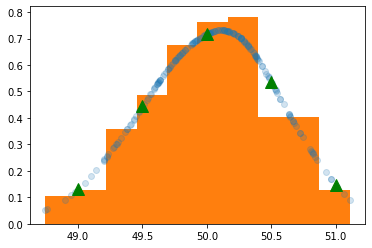

In [39]:
plt.plot(X, kde.score_samples(X).numpy(), 'o', alpha=0.2)
plt.plot(waypoints, kde.score_samples(inter), '^g', markersize=12)
plt.hist(X.numpy(), density=True)
plt.show()

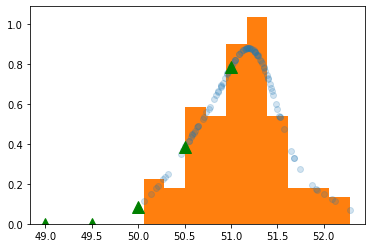

In [40]:
plt.plot(Y, kde2.score_samples(Y).numpy(), 'o', alpha=0.2)
plt.plot(waypoints, kde2.score_samples(inter), '^g', markersize=12)
plt.hist(Y.numpy(), density=True)
plt.show()

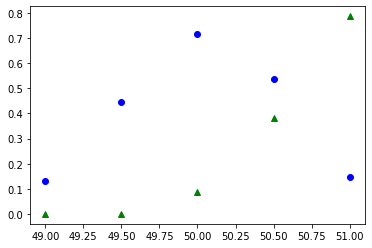

In [41]:
plt.plot(waypoints, kde.score_samples(inter), 'ob')
plt.plot(waypoints, kde2.score_samples(inter), '^g')

In [16]:
c1=kde.score_samples(inter)
c2=kde2.score_samples(inter)

sum(torch.square(c1 - c2))

tensor([6.4929e-05])